In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.models import Model
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


print("TensorFlow version:", tf.__version__)
print("MediaPipe version:", mp.__version__)

Mounted at /content/drive
TensorFlow version: 2.18.0
MediaPipe version: 0.10.21


In [2]:
# --- KONFIGURASI ---
DATA_DIR = '/content/drive/MyDrive/Skripsi/dataset/dataset_augmented/BISINDO' # Ganti ke SIBI jika perlu
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_LANDMARKS = 42 * 3 # 126 (untuk 2 tangan)
EPOCHS = 200
FINE_TUNE_EPOCHS = 100

# --- INISIALISASI MEDIAPIPE ---
mp_hands = mp.solutions.hands
hands_model = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

# --- FUNGSI GENERATOR DATA (LOGIKA MIRRORING BARU) ---
CLASS_NAMES = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
NUM_CLASSES = len(CLASS_NAMES)
class_to_int = {label: i for i, label in enumerate(CLASS_NAMES)}

def data_generator():
    for label_name in CLASS_NAMES:
        label_dir = os.path.join(DATA_DIR, label_name)
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)

            # Baca gambar dengan OpenCV untuk pemrosesan landmark
            cv_image = cv2.imread(image_path)
            if cv_image is None: continue

            # --- DATA ASLI ---
            # 1. Ekstrak landmark dari gambar asli
            image_rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
            results = hands_model.process(image_rgb)
            landmarks_vector_original = np.zeros(NUM_LANDMARKS, dtype=np.float32)
            if results.multi_hand_landmarks:
                for i, hand_landmarks in enumerate(results.multi_hand_landmarks):
                    handedness = results.multi_handedness[i].classification[0].label
                    coords = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
                    relative_coords = (coords - coords[0]).flatten()
                    if handedness == 'Right': landmarks_vector_original[0:63] = relative_coords
                    elif handedness == 'Left': landmarks_vector_original[63:126] = relative_coords

            # 2. Siapkan gambar asli untuk CNN
            image_original_tf = tf.convert_to_tensor(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
            image_original_tf = tf.image.resize(image_original_tf, IMAGE_SIZE)

            # 3. Yield data asli
            yield {'image_input': image_original_tf, 'landmark_input': landmarks_vector_original}, class_to_int[label_name]

            # --- DATA CERMIN (AUGMENTASI ON-THE-FLY) ---
            # 1. Flip gambar
            flipped_image = cv2.flip(cv_image, 1)

            # 2. Ekstrak landmark dari gambar yang sudah di-flip
            flipped_image_rgb = cv2.cvtColor(flipped_image, cv2.COLOR_BGR2RGB)
            results_flipped = hands_model.process(flipped_image_rgb)
            landmarks_vector_flipped = np.zeros(NUM_LANDMARKS, dtype=np.float32)
            if results_flipped.multi_hand_landmarks:
                for i, hand_landmarks in enumerate(results_flipped.multi_hand_landmarks):
                    # Perhatikan handedness sekarang terbalik
                    handedness = results_flipped.multi_handedness[i].classification[0].label
                    coords = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
                    relative_coords = (coords - coords[0]).flatten()
                    # Logika dibalik: Tangan 'Right' di gambar cermin adalah 'Left' di dunia nyata
                    if handedness == 'Right': landmarks_vector_flipped[63:126] = relative_coords
                    elif handedness == 'Left': landmarks_vector_flipped[0:63] = relative_coords

            # 3. Siapkan gambar flip untuk CNN
            image_flipped_tf = tf.convert_to_tensor(flipped_image_rgb)
            image_flipped_tf = tf.image.resize(image_flipped_tf, IMAGE_SIZE)

            # 4. Yield data cermin
            yield {'image_input': image_flipped_tf, 'landmark_input': landmarks_vector_flipped}, class_to_int[label_name]

print("Generator siap dengan on-the-fly mirroring.")

Generator siap dengan on-the-fly mirroring.


In [3]:
output_signature = (
    {'image_input': tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
     'landmark_input': tf.TensorSpec(shape=(NUM_LANDMARKS,), dtype=tf.float32)},
    tf.TensorSpec(shape=(), dtype=tf.int32)
)
dataset = tf.data.Dataset.from_generator(data_generator, output_signature=output_signature)

# PERUBAHAN: Ukuran dataset sekarang 2x lipat
DATASET_SIZE = sum([len(files) for r, d, files in os.walk(DATA_DIR)]) * 2
train_size = int(0.8 * DATASET_SIZE)

dataset = dataset.shuffle(buffer_size=2048) # Buffer lebih besar lebih baik
train_dataset = dataset.take(train_size).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
validation_dataset = dataset.skip(train_size).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print("Pipeline data dengan mirroring on-the-fly telah siap.")

Pipeline data dengan mirroring on-the-fly telah siap.


In [4]:
# --- DEFINISI LAYER AUGMENTASI (BARU) ---
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1), # Rotasi acak sebesar maks 10%
    layers.RandomZoom(0.1),     # Zoom acak sebesar maks 10%
    layers.RandomContrast(0.1), # Kontras acak sebesar maks 10%
], name="data_augmentation")


# --- BANGUN ARSITEKTUR MODEL ---

# --- Cabang 1: Visual (CNN) dengan Augmentasi ---
input_image = Input(shape=(*IMAGE_SIZE, 3), name='image_input')

# Terapkan augmentasi data setelah input
augmented_image = data_augmentation(input_image)

# Lanjutkan dengan rescaling pada gambar yang sudah diaugmentasi
rescaling = tf.keras.layers.Rescaling(1./255)(augmented_image)

# Masukkan ke base model
base_model_cnn = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=rescaling)
base_model_cnn.trainable = False
visual_features = GlobalAveragePooling2D()(base_model_cnn.output)


# --- Cabang 2: Landmark (MLP) ---
input_landmarks = Input(shape=(NUM_LANDMARKS,), name='landmark_input') # NUM_LANDMARKS = 126
x = Dense(256, activation='relu')(input_landmarks)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
landmark_features = Dense(64, activation='relu')(x)

# --- Menggabungkan Kedua Cabang ---
combined_features = Concatenate()([visual_features, landmark_features])

# --- Classifier Akhir ---
x = Dropout(0.5)(combined_features)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# --- Membuat Model Akhir ---
model = Model(inputs=[input_image, input_landmarks], outputs=output, name='Hybrid_Sign_Language_Model_Augmented')

# --- Kompilasi Model ---
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Hybrid_Sign_Language_Model_Augmented"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 128, 128,  │          0 │ image_input[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc

 Total params: 4,158,205 (15.86 MB)

 Trainable params: 108,634 (424.35 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
print("Memulai proses training awal...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    verbose=1
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Memulai proses training awal...
Epoch 1/200
    159/Unknown 561s 3s/step - accuracy: 0.4244 - loss: 1.7317

In [ ]:
base_model_cnn.trainable = True
fine_tune_at = 150
for layer in base_model_cnn.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model siap untuk di-fine-tune.")
model.summary()

Model siap untuk di-fine-tune.


Model: "Hybrid_Sign_Language_Model_Augmented"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 128, 128,  │          0 │ image_input[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 128, 128,  │          0 │ data_augmentatio… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 128, 128,  │          0 │ rescaling_3[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 128, 128,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 128, 128,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc

 Total params: 4,158,205 (15.86 MB)

 Trainable params: 3,472,946 (13.25 MB)

 Non-trainable params: 685,259 (2.61 MB)

Memulai proses fine-tuning...
Epoch 200/300
130/130 ━━━━━━━━━━━━━━━━━━━━ 61s 118ms/step - accuracy: 0.8272 - loss: 1.3724 - val_accuracy: 0.9952 - val_loss: 0.0227
Epoch 201/300
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8910 - loss: 0.5260 - val_accuracy: 0.9894 - val_loss: 0.0417
Epoch 202/300
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9294 - loss: 0.2460 - val_accuracy: 0.9904 - val_loss: 0.0355
Epoch 203/300
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9573 - loss: 0.1525 - val_accuracy: 0.9962 - val_loss: 0.0257
Epoch 204/300
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9666 - loss: 0.1049 - val_accuracy: 0.9962 - val_loss: 0.0243
Epoch 205/300
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9755 - loss: 0.0908 - val_accuracy: 0.9962 - val_loss: 0.0221
Epoch 206/300
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9786 - loss: 0.0678 - val_accuracy: 0.9962 - val_loss: 0.0194
Epoch 207/300
130/130 ━━━━━━━━━━━━━━━━━━━━ 

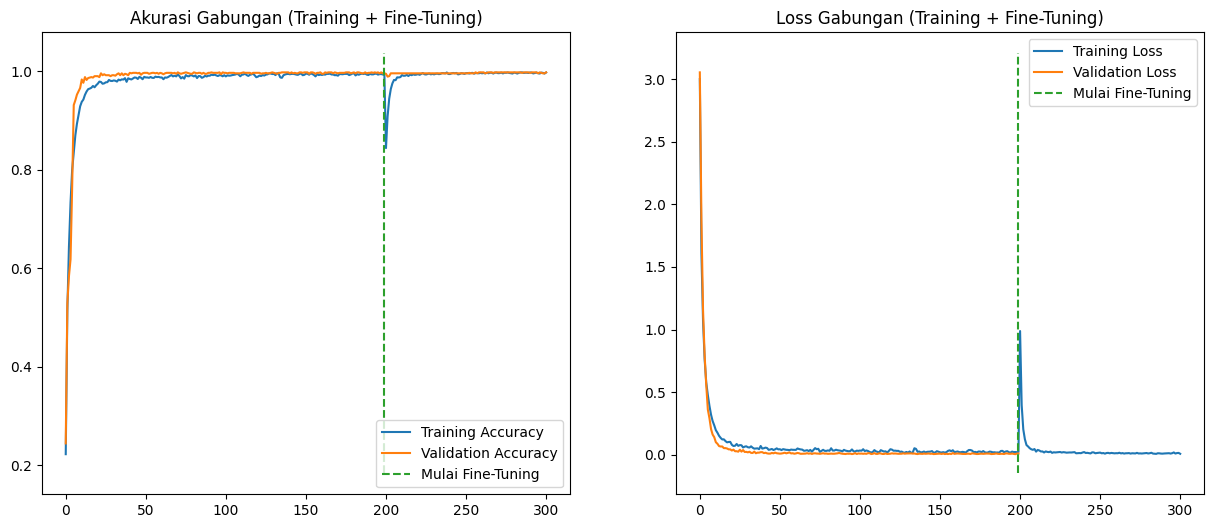

In [ ]:
total_epochs = EPOCHS + fine_tune_epochs

print("Memulai proses fine-tuning...")
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Melanjutkan dari epoch terakhir
    validation_data=validation_dataset,
    verbose=1
)

# Gabungkan history dari training awal dan fine-tuning
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss']

# Plot
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Mulai Fine-Tuning', linestyle='--')
plt.legend(loc='lower right')
plt.title('Akurasi Gabungan (Training + Fine-Tuning)')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Mulai Fine-Tuning', linestyle='--')
plt.legend(loc='upper right')
plt.title('Loss Gabungan (Training + Fine-Tuning)')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Skripsi/models/Bisindo_hybrid_model_v3_finetuned.keras')
print("Model hasil fine-tuning berhasil disimpan sebagai 'bisindo_hybrid_model_v3_finetuned.keras'")

Model hasil fine-tuning berhasil disimpan sebagai 'bisindo_hybrid_model_v2_finetuned.keras'
